# Capital Asset Pricing Model (CAPM)

Measures Systematic Risk (market risk). This risk cannot be diversified away (e.g. interest rates, recession or war)

$$ E[r_a] = r_f + \beta_a(E[r_m] - r_f) $$

The expected return of an investment $r_a$ (can be a single stock or portfolio) is equal to the base return $r_f$ (because of risk-free rate) plus the market excess return multiplied by a factor $\beta$.\
$E[r_m]$ is the return of the market itself, it can be represented by the S&P500. S&P500 measures the stock performance of 500 large companies listed on stock exchanges in the United States. It includes the 500 most important and most relevant stocks within the leading industries.

$$ \beta_a = \frac{Cov(r_a,r_m)}{Var(r_m)} $$

$\beta_a$ is the only relevant measure of a stock's risk. Measures how much the price of a given stock goes up or down compared to the whole market.\
$\beta_a$ = how risky your portfolio is relative to the market. If portfolio has no risk, the return is equal to the risk-free return. $\beta_a$ risk is proportional to the return.

$\beta_a = \omega_1\beta_1+\omega_2\beta_2+\omega_3\beta_3+...$ 

$\beta = 1$: Stock moving exactly with the market.\
$\beta > 1$: Stock market risk is higher than average stock, more return.\
$\beta < 1$: Stock market risk is lower than average stock, less return.

In [6]:
import pandas_datareader as pdr
from pandas_datareader import data, wb
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import r2_score
import scipy.optimize as opt

In [7]:
risk_free_rate = 0.05

## Course Implementation

In [8]:
def capm(start_date,end_date, ticker1,ticker2):
    #get the data from Yahoo Finance
    stock1 = pdr.get_data_yahoo(ticker1, start_date, end_date)
    stock2 = pdr.get_data_yahoo(ticker2, start_date, end_date)
    
    
    #we prefer monthly returns instead of daily returns
    return_stock1 = stock1.resample('M').last()
    return_stock2 = stock2.resample('M').last()

    #creating a dataFrame from the data - Adjusted Closing Price is used as usual
    data = pd.DataFrame({'s_adjclose' : return_stock1['Adj Close'], 'm_adjclose' : return_stock2['Adj Close']}, index=return_stock1.index)
    print(data)
    #natural logarithm of the returns
    data[['s_returns', 'm_returns']] = np.log(data[['s_adjclose','m_adjclose']]/data[['s_adjclose','m_adjclose']].shift(1))
    
    #no need for NaN/missing values values so let's get rid of them
    data = data.dropna()
    print(data)
    #covariance matrix: the diagonal items are the variances - off diagonals are the covariances
    #the matrix is symmetric: cov[0,1] = cov[1,0] !!!
    covmat = np.cov(data["s_returns"], data["m_returns"])
    print(covmat)
    
    #calculating beta according to the formula
    beta = covmat[0,1]/covmat[1,1]
    print("Beta from formula:", beta)

    #using linear regression to fit a line to the data [stock_returns, market_returns] - slope is the beta
    beta,alpha = np.polyfit(data["m_returns"], data['s_returns'], deg=1)
    print("Beta from regression:", beta)

    #plot
    fig,axis = plt.subplots(1,figsize=(20,10))
    axis.scatter(data["m_returns"], data['s_returns'], label="Data points")
    axis.plot(data["m_returns"], beta*data["m_returns"] + alpha, color='red', label="CAPM Line")
    plt.title('Capital Asset Pricing Model, finding alphas and betas')
    plt.xlabel('Market return $R_m$', fontsize=18)
    plt.ylabel('Stock return $R_a$')
    plt.text(0.08, 0.05, r'$R_a = \beta * R_m + \alpha$', fontsize=18)
    plt.legend()
    plt.grid(True)
    plt.show()

    #calculate the expected return according to the CAPM formula
    expected_return = risk_free_rate + beta*(data["m_returns"].mean()*12-risk_free_rate)
    print("Expected return:", expected_return)

            s_adjclose   m_adjclose
Date                               
2010-06-30   88.006813  1030.709961
2010-07-31   91.513382  1101.599976
2010-08-31   88.192184  1049.329956
2010-09-30   96.078125  1141.199951
2010-10-31  102.853882  1183.260010
...                ...          ...
2019-08-31  129.118759  2926.459961
2019-09-30  138.540909  2976.739990
2019-10-31  127.403915  3037.560059
2019-11-30  129.602737  3140.979980
2019-12-31  129.207504  3230.780029

[115 rows x 2 columns]
            s_adjclose   m_adjclose  s_returns  m_returns
Date                                                     
2010-07-31   91.513382  1101.599976   0.039071   0.066516
2010-08-31   88.192184  1049.329956  -0.036967  -0.048612
2010-09-30   96.078125  1141.199951   0.085643   0.083928
2010-10-31  102.853882  1183.260010   0.068148   0.036193
2010-11-30  101.771370  1180.550049  -0.010581  -0.002293
...                ...          ...        ...        ...
2019-08-31  129.118759  2926.459961  -0.0779

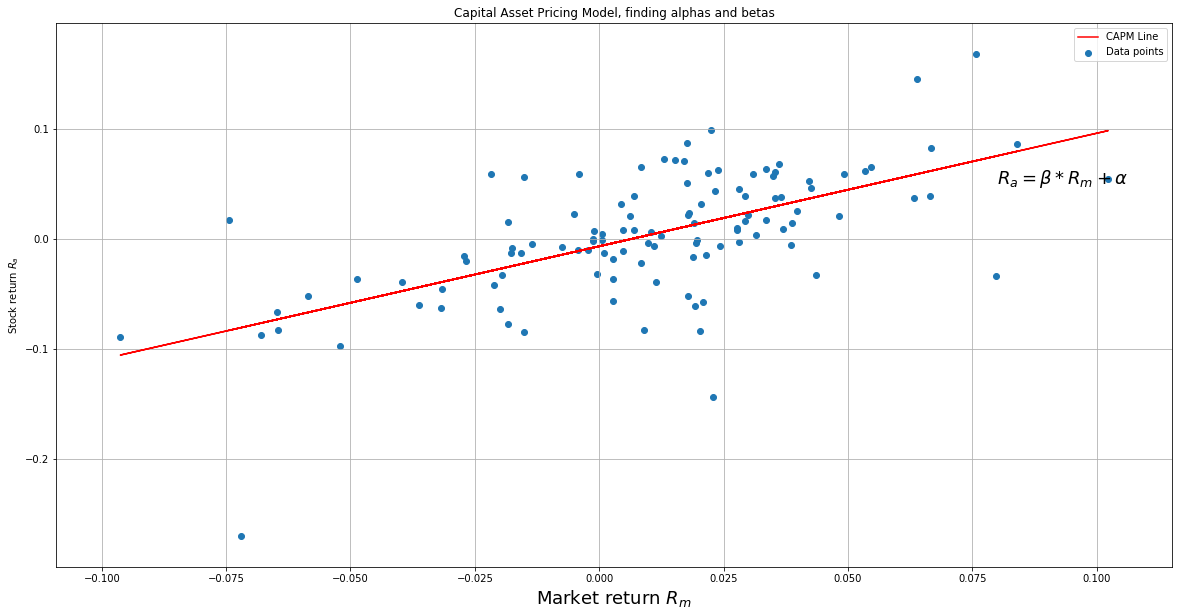

Expected return: 0.12209849146776006


In [9]:
capm('2010-06-26', '2020-01-01','IBM', '^GSPC')

## Determination of the Beta parameter from a given portfolio 

### We obtain the stocks values by month

In [10]:
# Expected Return from a portfolio:

def get_stocks(start_date,end_date,portfolio_list,market):
    ''' start_date:  date string (e.g. 2010-01-01 )
        end_date: date string
        portfolio_list: List of string (e.g. ['IBM','AMZN','APPL'])
        market: String (e.g. '^GSPC' is to obtain the S&P500 stocks)'''
    
    stocks_list = []
    
    # First stocks is from the market values:
    stock_market = pdr.get_data_yahoo(market, start_date, end_date)
    stocks_list.append(stock_market.resample('M').last())
    
    # Next stocks are from the portfolio:
    for elem in portfolio_list:
        stock = pdr.get_data_yahoo(elem,start_date,end_date)
        stocks_list.append(stock.resample('M').last())
        
    return stocks_list

### We define the portfolio (Apple, Walmart, Tesla, General Electrics, Amazon, IBM and Microsoft are included) and the market ^GSPC is the S&P500

In [11]:
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN' , 'IBM','MSFT']
market_price = '^GSPC'
datefirst = '2010-01-01'
datelast = '2020-01-01'

stock_lists = get_stocks(datefirst,datelast,stocks,market_price)

In [12]:
for i in range(len(stocks)): 
#     zip(stocks,stock_lists):
    print(stocks[i])
    print(stock_lists[i+1]['Adj Close'])
    print(' ')

AAPL
Date
2010-01-31     5.927377
2010-02-28     6.315006
2010-03-31     7.252596
2010-04-30     8.057792
2010-05-31     7.927861
                ...    
2019-08-31    51.672314
2019-09-30    55.442406
2019-10-31    61.579021
2019-11-30    66.354729
2019-12-31    72.909500
Freq: M, Name: Adj Close, Length: 120, dtype: float64
 
WMT
Date
2010-01-31     40.939312
2010-02-28     41.429668
2010-03-31     42.841732
2010-04-30     41.331478
2010-05-31     39.184189
                 ...    
2019-08-31    112.291061
2019-09-30    116.634895
2019-10-31    115.239372
2019-11-30    117.037827
2019-12-31    117.316002
Freq: M, Name: Adj Close, Length: 120, dtype: float64
 
TSLA
Date
2010-06-30     4.766000
2010-07-31     3.988000
2010-08-31     3.896000
2010-09-30     4.082000
2010-10-31     4.368000
                ...    
2019-08-31    45.122002
2019-09-30    48.174000
2019-10-31    62.984001
2019-11-30    65.987999
2019-12-31    83.666000
Freq: M, Name: Adj Close, Length: 115, dtype: float64
 


### We obtain the returns of each stock and the main market (Monthly)

In [13]:
# Get the returns dataframe 
def get_returns(stocks_lists,portfolio_list,market):
    '''Obtain the return values of each stock, including the market stock,
        stocks_lists: list of dataframes [market_stocks,stocks1,stocks2,..]
        portfolio_list: List of string (e.g. ['IBM','AMZN','APPL']
        market: String (e.g. '^GSPC' is to obtain the S&P500 stocks) '''
    new_stocks_list = portfolio_list.copy()
    new_stocks_list.insert(0,market)
#     portfolio_list.insert(0,market)
    # Create a stocks dictionary and Dataframe with the Adj Close values
    stock_dictionary = {name+'_adjclose':stock['Adj Close'] for name,stock in zip(new_stocks_list,stocks_lists)}
    data = pd.DataFrame(stock_dictionary,index=stocks_lists[0].index)
    
    # Create a return dictionary with the calculation of the return using the log formula between the Adj Close values
    return_data_dict = {}
    for name in new_stocks_list:
        return_data_dict[name+'_return']=np.log(data[name+'_adjclose']/data[name+'_adjclose'].shift(1))
    
    # Create dataframe
    return_data = pd.DataFrame(return_data_dict,index = stocks_lists[0].index)
    
    #no need for NaN/missing values values so let's get rid of them
    return_data = return_data.dropna()
    return return_data

In [14]:
returns_stocks = get_returns(stock_lists,stocks,market_price)

In [42]:
returns_stocks

,^GSPC_return,AAPL_return,WMT_return,TSLA_return,GE_return,AMZN_return,IBM_return,MSFT_return
Date,,,,,,,,
2010-07-31,0.066516,0.022486,0.062886,-0.178218,0.111445,0.076022,0.039071,0.114833
2010-08-31,-0.048612,-0.056575,-0.014915,-0.023339,-0.107293,0.057201,-0.036967,-0.089718
2010-09-30,0.083928,0.154620,0.065237,0.046637,0.122992,0.229675,0.085643,0.042542
2010-10-31,0.036193,0.058950,0.012072,0.067718,-0.014255,0.050711,0.068148,0.085274
2010-11-30,-0.002293,0.033231,-0.001478,0.480989,-0.011931,0.059731,-0.010581,-0.048192
...,...,...,...,...,...,...,...,...
2019-08-31,-0.018257,-0.016598,0.039458,-0.068517,-0.236389,-0.049688,-0.077926,0.014925
2019-09-30,0.017035,0.070423,0.037954,0.065449,0.081403,-0.022995,0.070433,0.008451
2019-10-31,0.020226,0.104977,-0.012037,0.268061,0.110048,0.023203,-0.083803,0.030739


### We can calculate beta from the covariances between the stocks returns and the market return and the variance of the return of the market

$$ \beta_i = \frac{Cov(r_i,r_m)}{Var(r_m)} $$
$$\beta_a = \omega_1\beta_1+\omega_2\beta_2+\omega_3\beta_3+...$$
$$\beta_a = \sum_i \frac{Cov(r_i,r_m)}{Var(r_m)}$$

In [16]:
def beta_CovarianceMatrix(return_data,weights,market):
    '''Calculate the beta parameter for a given portfolio
        return_data: Dataframe with the given returns of each stock, including the
        markets return (e.g. {market_return,stock_return1,...})
        weights: The stocks weights for the portfolio
        market: String (e.g. '^GSPC' is to obtain the S&P500 stocks)'''
    # Covariance Matrix
    covarianceMat = return_data.cov()
#     print(covarianceMat)
    covariances = covarianceMat[market+'_return']
    beta_values = covariances[1:]/covariances[0]
#     print('Beta Values Covariance Matrix: ',np.array(beta_values))
    beta = np.dot(beta_values,weights)
    return beta

### We can calculate beta from linear regression between the expected return from the portfolio and the expected return from the market

$$ \beta_a = \frac{E[r_a] - r_f}{E[r_m] - r_f} $$

In [17]:
def beta_LinearRegression(return_data,weights,portfolio_list,market):
    '''Calculate the beta parameter for a given portfolio using linear regression
        returm_data: Dataframe with the given returns of each stock, including the
        markets return (e.g. {market_return,stock_return1,...})
        weights: The stocks weights for the portfolio
        portfolio_list: List of string (e.g. ['IBM','AMZN','APPL']
        market: String (e.g. '^GSPC' is to obtain the S&P500 stocks)'''

    # For each iteration we need the market's return
    market_return = np.asanyarray([return_data[market+'_return']]).T
    # We add a '_return' to the stocks names to access the dataframe
    stocks_return_names = [stock + '_return' for stock in portfolio_list]
    
    # Create a matrix contaning the returns for each stocks
    stocks_returns_data = np.asanyarray(return_data[stocks_return_names])
    
    # Create linear model and make multidimensional linear regression between the market return and each
    # stock return
    regr = linear_model.LinearRegression()
    regr.fit(market_return,stocks_returns_data)
    
    # Print Coefficients, they should be the beta parameters for each return
    print ('Beta Values Linear Regression: ', regr.coef_.T[0])
    
    # Calculate the general beta parameter as the linear combination of each individual beta and weigths.
    beta = np.dot(regr.coef_.T[0],weights)
    
    return beta

#### We create random weights

In [18]:
# Random Weights:
def initialize_weights(stock_list):
    weights = np.random.random(len(stock_list))
    weights /= sum(weights)
    return weights
w = initialize_weights(stocks)
print(w)

[0.20571509 0.12687699 0.17754939 0.01465106 0.19087735 0.20893821
 0.07539191]


In [19]:
# Beta Value
beta_cov = beta_CovarianceMatrix(returns_stocks,w,market_price)
beta_regr = beta_LinearRegression(returns_stocks,w,stocks,market_price)
print(beta_cov)
print(beta_regr)

Beta Values Linear Regression:  [1.05635057 0.37953299 0.62560336 1.23695863 1.20281128 1.02615812
 1.00566348]
0.9144714698821877
0.9144714698821879


### MonteCarlo Simulation of random weights to generate beta values 

In [20]:
# Can we optimize the weights so that the beta parameter can be maximum or minimum
def generate_beta_values(return_data,market,portfolio_list):
    
    beta_list = []
    weights_list = []
    
    for i in range(80000):
        weights = initialize_weights(portfolio_list)
        beta = beta_CovarianceMatrix(return_data,weights,market)
        weights_list.append(weights)
        beta_list.append(beta)
    
    return np.array(beta_list), np.array(weights_list).T

In [21]:
betas , weig = generate_beta_values(returns_stocks,market_price,stocks)

#### We plot the relation between a sample of random weights and beta values

In [22]:
def plot_beta(beta_list,weight_list):
    fig,ax = plt.subplots(figsize = (10,8))
    ax.set_xlabel('Weight',fontsize = 'large')
    ax.set_ylabel('Beta',fontsize = 'large')
    s = ax.scatter(weight_list,beta_list,c='k',s=0.8)
    plt.title('Beta vs Weight')
    plt.grid()
#     fig.colorbar(s ,label = 'Sharpe Ratio')
    plt.show() 

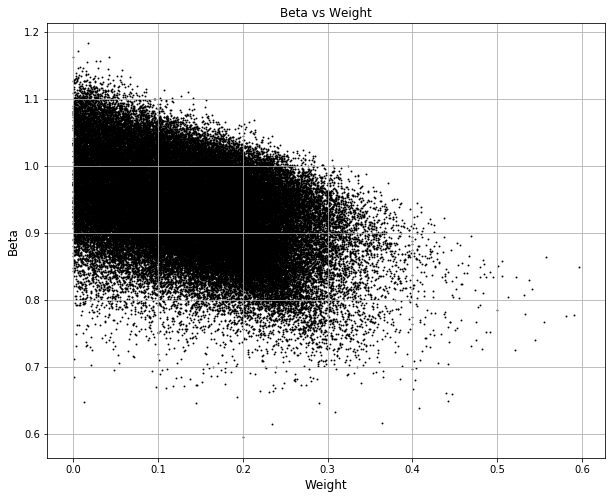

In [23]:
plot_beta(betas,weig[2])

#### Expected return formula

$$ E[r_a] = r_f + \beta_a(E[r_m] - r_f) $$

In [24]:
def expected_return(market_name,returns_data,beta):
    expected_stocks_ret = risk_free_rate + beta*(returns_data[market_name+'_return'].mean()*12-risk_free_rate)
    return expected_stocks_ret

### We plot the beta values generated for each random weights generated for each stock in the Montecarlo simulation and see the main relation between them

In [25]:
def beta_scatter_plots(beta_list,weight_list,stocks_list,market_name,return_data):
    fig = plt.figure(figsize=(15,22))
    for i,stock in enumerate(stocks_list):
        ax = fig.add_subplot(4,2,i+1)
        ax.set_xlabel('Weight',fontsize = 'large')
        ax.set_ylabel('Beta',fontsize = 'large')
        s = ax.scatter(weight_list[i],beta_list,s=0.8,c=expected_return(market_name,return_data,beta_list),cmap='winter')
        fig.colorbar(s ,label = 'Expected Return')
        plt.title(stock)
        plt.grid(True)
        
    plt.show()

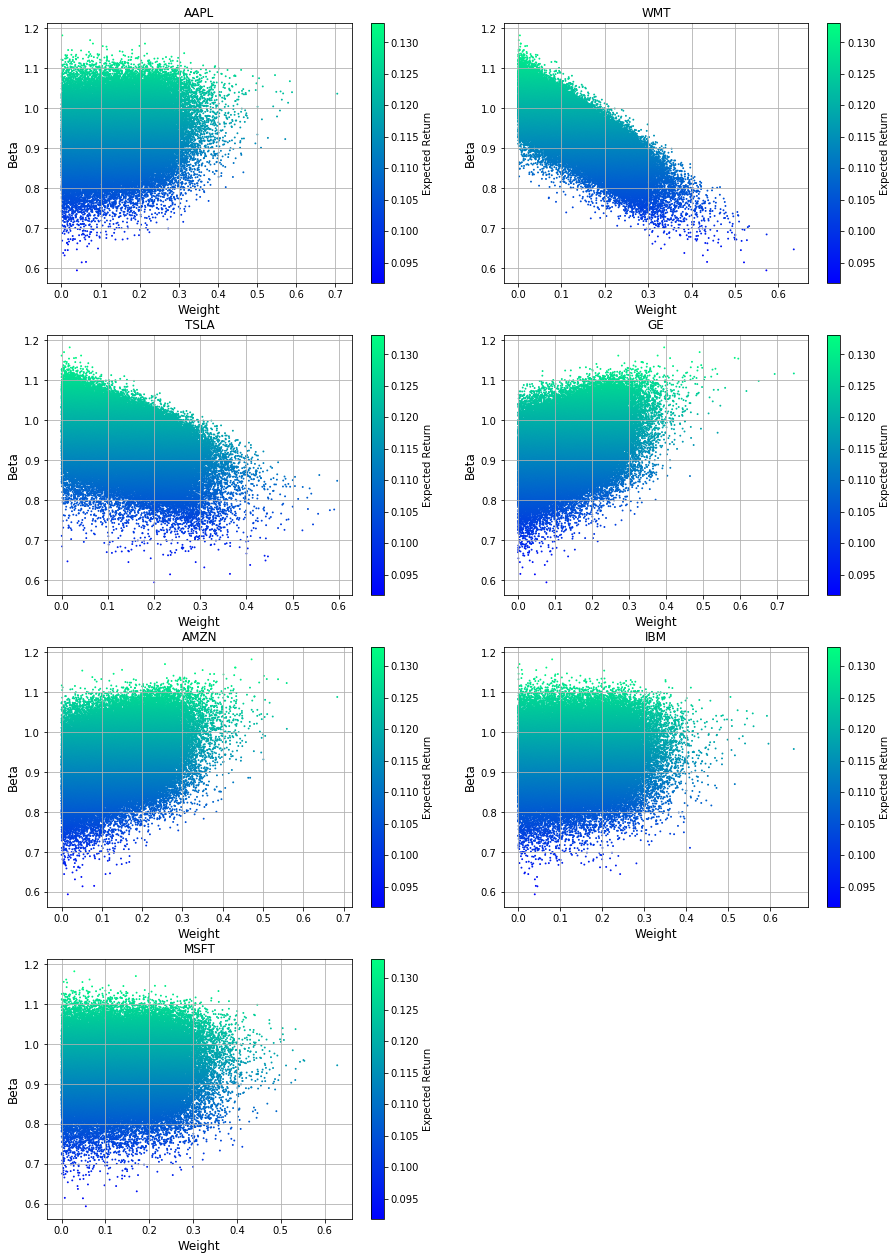

In [26]:
beta_scatter_plots(betas,weig,stocks,market_price,returns_stocks)

From these graphs we can see that some stocks have more impact in the beta value, which beta value we asign to each stock will determine the return expectancy at the end. To find out what these influence is about, let's see how the distributions of each stock's return since the return of each stock will determine the beta value.

In [27]:
def returns_histograms(return_data,stocks_list):
    fig = plt.figure(figsize=(15,24))
    for i,stock in enumerate(stocks_list):
        
        histogram ,bin_edge = np.histogram(return_data[stock+'_return'],bins=50,density=True) 
        width = np.diff(bin_edge)[0]
        ax = fig.add_subplot(4,2,i+1)
        ax.set_xlabel('Return',fontsize = 'large')
        ax.set_ylabel('Frequency',fontsize = 'large')
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        ax.bar(bin_edge[:-1], histogram, color='w',edgecolor='k',width=width)
        plt.xlim(min(bin_edge), max(bin_edge))
        
        plt.title(stock)
        plt.grid(True)
        
    plt.show() 

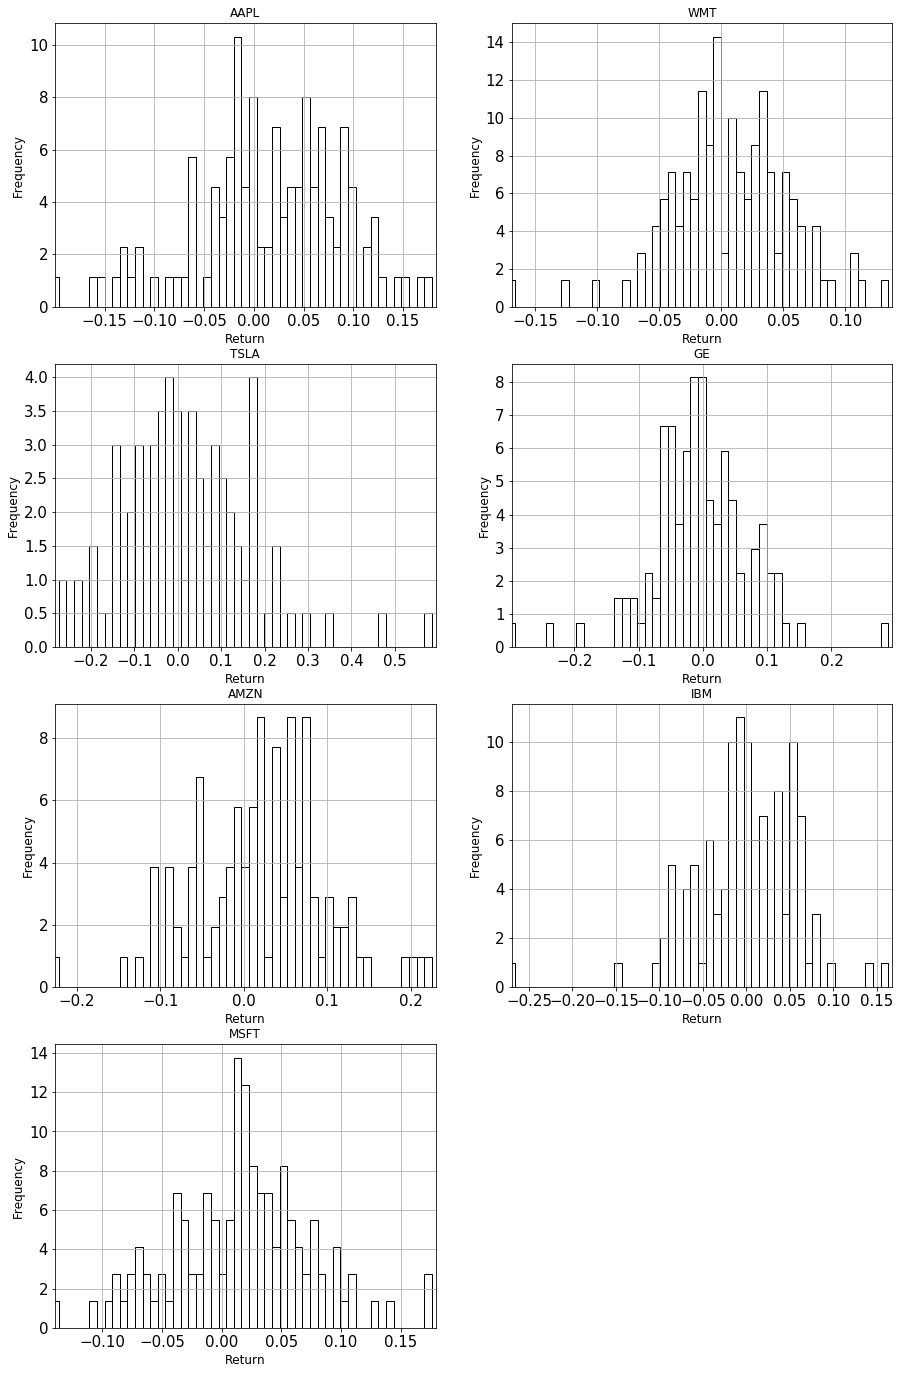

In [28]:
returns_histograms(returns_stocks,stocks)

We can see that the returns of each stock doesn't have a particular distribution

In [39]:
def beta_dist(bin_edge,histograms,title):
    width=np.diff(bin_edge)[0]
    plt.figure(figsize=[10,6])
    plt.bar(bin_edge[:-1], histograms, color='b',width=width)
    plt.xlim(min(bin_edge), max(bin_edge))
    
    plt.xlabel('Value',fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.title(title,fontsize=15)
    plt.show()

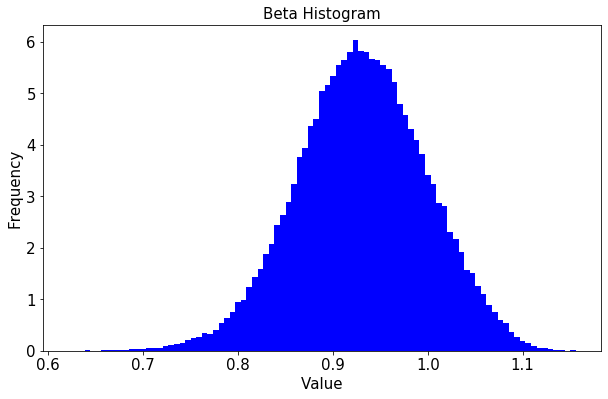

In [40]:
hist, bin_edges = np.histogram(betas,bins = 100,density=True)
# norm = sum(hist*np.diff(bin_edges))

beta_dist(bin_edges,hist,'Beta Histogram')

In the other hand, the beta values generated from the Montecarlo simulation have a normal distribution

We can determine the optimal weigths by maximizing the expected return for each stock.

### Optimal Portfolio to maximize the expected return from the stocks's portfolio

In [31]:
def min_expected_return(weights,return_data,market_name):
    expected_stocks_ret = risk_free_rate + beta_CovarianceMatrix(return_data,weights,market_name)*(return_data[market_name+'_return'].mean()*12-risk_free_rate)
    return -expected_stocks_ret

In [32]:
# weights: initial guess
# returns: aditional arguments
def optimize_portfolio(weights , return_data , market_name):
    constraints = {'type':'eq','fun':lambda x: np.sum(x)-1}
    bounds = tuple((0,1) for x in range(len(stocks)))
    optimum = opt.minimize(min_expected_return, x0 = weights , args = (return_data,market_name), method = 'SLSQP', bounds = bounds,\
                          constraints = constraints)
    return optimum

w = initialize_weights(stocks)

optimal_portfolio = optimize_portfolio(w,returns_stocks,market_price)
print('Optimal Portfolio Weights: ',optimal_portfolio['x'].round(4))
w_optimal = optimal_portfolio['x'].round(4)
b_optimal = beta_CovarianceMatrix(returns_stocks,w_optimal,market_price)
expected = expected_return(market_price,returns_stocks,b_optimal)
print('Highest Beta: ',b_optimal)
print('Max Beta from Montecarlo simulation: ', max(betas))
print('Highest Expected Return: ',expected)

print('Expected Return from montecarlo Simulation: ',expected_return(market_price,returns_stocks,max(betas)))
# print('Expected Return from montecarlo Simulation 2: ',max(expected_return(market_price,returns_stocks,betas)))

Optimal Portfolio Weights:  [0. 0. 0. 1. 0. 0. 0.]
Highest Beta:  1.2369586276776678
Max Beta from Montecarlo simulation:  1.182313731458586
Highest Expected Return:  0.13690946264196135
Expected Return from montecarlo Simulation:  0.13307007912479193
